<a href="https://colab.research.google.com/github/ismailasy/Deep_IOT_Network_Anomaly_Detection/blob/main/UNSW_LSTM_Classification_binaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
pip install  bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D,LSTM, MaxPooling2D,UpSampling2D,Conv2DTranspose, Dropout, Flatten, Activation, LeakyReLU, ReLU, Input,concatenate,BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D,LSTM, MaxPooling2D,UpSampling2D,Conv2DTranspose, Dropout, Flatten, Activation, LeakyReLU, ReLU, Input,concatenate,BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
from google.colab import files 
  
  
uploaded = files.upload()

Saving UNSW_NB15_testing.csv to UNSW_NB15_testing (1).csv
Saving UNSW_NB15_training.csv to UNSW_NB15_training (1).csv


In [54]:
import pandas as pd 
import io 
  
df_train = pd.read_csv(io.BytesIO(uploaded['UNSW_NB15_training.csv']))  
df_test =  pd.read_csv(io.BytesIO(uploaded['UNSW_NB15_testing.csv']))  

In [55]:
#supprimer les colonnes inutiles
df_train.drop('id', axis=1, inplace=True)
df_train.drop('attack_cat', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)
df_test.drop('attack_cat', axis=1, inplace=True)

In [56]:
#Nous concaténons l'ensemble d'apprentissage et l'ensemble de test pour manipuler directement l'ensemble.
df = pd.concat([df_train,df_test],axis=0)

In [57]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


In [58]:
df.shape

(257673, 43)

In [59]:
df_class_Normal = df[df['label'] == 0]
df_class_Attack = df[df['label'] == 1]


In [60]:
#Sous-échantillonnage de la catégorie d'attaque jusqu'à atteindre la même valeur que la catégorie Normal
df_class_Attack = df_class_Attack.sample(df_class_Normal.shape[0])
#Concaténé
df = pd.concat([df_class_Normal,df_class_Attack], axis=0)

In [61]:
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50120,0.000010,udp,-,INT,2,0,694,0,100000.002500,254,...,6,1,22,0,0,0,6,23,0,1
6808,0.000004,leaf-2,-,INT,2,0,200,0,250000.000600,254,...,2,2,6,0,0,0,4,6,0,1
60512,0.340151,tcp,-,FIN,10,6,756,268,44.098061,254,...,2,1,2,0,0,0,2,5,0,1
156547,0.000003,udp,dns,INT,2,0,114,0,333333.321500,254,...,11,11,27,0,0,0,12,27,0,1


Forme de dataFrame: (186000, 43) 

Nombre d'échantillons d'attaque


0    93000
1    93000
Name: label, dtype: int64


Tracer l'équilibre de dataFrame


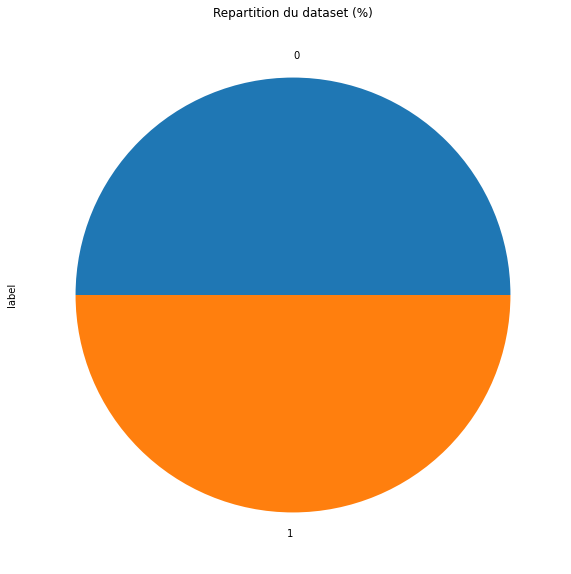

In [62]:
#Visualisation dans un graphique circulaire du poids de chaque classe
print("Forme de dataFrame: {} \n".format(df.shape))
print("Nombre d'échantillons d'attaque")
display(df['label'].value_counts())
print("")
print("Tracer l'équilibre de dataFrame")
df_plot = (df['label'].value_counts(normalize=True) *100)
df_plot.plot(kind='pie',figsize=(10,10),title='Repartition du dataset (%)')

In [63]:
#Conversion de la chaîne de type de données en nombres entiers dans une plage comprise entre 0 et 255 (1 octet d'informations)
def encode_string_byte (df,name):
  df[name] = LabelEncoder().fit_transform(df[name])

encode_string_byte (df,'proto')
encode_string_byte (df,'state') 
encode_string_byte (df,'service') 

In [64]:
#Normalisation des nombres entiers en valeurs décimales comprises entre 0 et 1
def numerical_minmax_normalization (df, name):
  x = df[name].values.reshape(-1,1)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df[name] = x_scaled

numerical_minmax_normalization(df,'dur')
numerical_minmax_normalization(df,'spkts')
numerical_minmax_normalization(df,'dpkts')
numerical_minmax_normalization(df,'sbytes')
numerical_minmax_normalization(df,'dbytes')
numerical_minmax_normalization(df,'rate')
numerical_minmax_normalization(df,'sttl')
numerical_minmax_normalization(df,'dttl')
numerical_minmax_normalization(df,'sload')
numerical_minmax_normalization(df,'dload')
numerical_minmax_normalization(df,'sloss')
numerical_minmax_normalization(df,'dloss')
numerical_minmax_normalization(df,'sinpkt')
numerical_minmax_normalization(df,'dinpkt')
numerical_minmax_normalization(df,'sjit')
numerical_minmax_normalization(df,'djit')
numerical_minmax_normalization(df,'swin')
numerical_minmax_normalization(df,'stcpb')
numerical_minmax_normalization(df,'dtcpb')
numerical_minmax_normalization(df,'dwin')
numerical_minmax_normalization(df,'tcprtt')
numerical_minmax_normalization(df,'synack')
numerical_minmax_normalization(df,'ackdat')
numerical_minmax_normalization(df,'smean')
numerical_minmax_normalization(df,'dmean')
numerical_minmax_normalization(df,'trans_depth')
numerical_minmax_normalization(df,'response_body_len')
numerical_minmax_normalization(df,'ct_srv_src')
numerical_minmax_normalization(df,'ct_state_ttl')
numerical_minmax_normalization(df,'ct_dst_ltm')
numerical_minmax_normalization(df,'ct_src_dport_ltm')
numerical_minmax_normalization(df,'ct_dst_sport_ltm')
numerical_minmax_normalization(df,'ct_dst_src_ltm')
numerical_minmax_normalization(df,'is_ftp_login')
numerical_minmax_normalization(df,'ct_ftp_cmd')
numerical_minmax_normalization(df,'ct_flw_http_mthd')
numerical_minmax_normalization(df,'ct_src_ltm')
numerical_minmax_normalization(df,'ct_srv_dst')
numerical_minmax_normalization(df,'is_sm_ips_ports')

In [65]:
#Mappage des valeurs normalisées de l'étape précédente sur des valeurs entières comprises entre 0 et 255 (1 Byte d'information)
def numerical_split_ohe (df,name):
  pd_to_np = df[name].tolist()
  np_split = []
  
  categories = np.linspace(0, 1, num=256,endpoint=False)
  quantization = range(0,256)

  for value in pd_to_np:
    for i in range(len(categories)-1):
      if (categories[i] <= float(value) <= categories[i+1]):
        np_split.append(quantization[i])
        break
      if (float(value) > categories[-1]):
        np_split.append(quantization[-1])
        break
  
  df[name] = np_split


numerical_split_ohe(df,'dur')
numerical_split_ohe(df,'spkts')
numerical_split_ohe(df,'dpkts')
numerical_split_ohe(df,'sbytes')
numerical_split_ohe(df,'dbytes')
numerical_split_ohe(df,'rate')
numerical_split_ohe(df,'sttl')
numerical_split_ohe(df,'dttl')
numerical_split_ohe(df,'sload')
numerical_split_ohe(df,'dload')
numerical_split_ohe(df,'sloss')
numerical_split_ohe(df,'dloss')
numerical_split_ohe(df,'sinpkt')
numerical_split_ohe(df,'dinpkt')
numerical_split_ohe(df,'sjit')
numerical_split_ohe(df,'djit')
numerical_split_ohe(df,'swin')
numerical_split_ohe(df,'stcpb')
numerical_split_ohe(df,'dtcpb')
numerical_split_ohe(df,'dwin')
numerical_split_ohe(df,'tcprtt')
numerical_split_ohe(df,'synack')
numerical_split_ohe(df,'ackdat')
numerical_split_ohe(df,'smean')
numerical_split_ohe(df,'dmean')
numerical_split_ohe(df,'trans_depth')
numerical_split_ohe(df,'response_body_len')
numerical_split_ohe(df,'ct_srv_src')
numerical_split_ohe(df,'ct_state_ttl')
numerical_split_ohe(df,'ct_dst_ltm')
numerical_split_ohe(df,'ct_src_dport_ltm')
numerical_split_ohe(df,'ct_dst_sport_ltm')
numerical_split_ohe(df,'ct_dst_src_ltm')
numerical_split_ohe(df,'is_ftp_login')
numerical_split_ohe(df,'ct_ftp_cmd')
numerical_split_ohe(df,'ct_flw_http_mthd')
numerical_split_ohe(df,'ct_src_ltm')
numerical_split_ohe(df,'ct_srv_dst')
numerical_split_ohe(df,'is_sm_ips_ports')

In [66]:
#Retirer la colonne attack_cat et l'enregistrer dans la variable y.
y_column = df['label']
df.drop('label',axis=1,inplace=True)
dummies = pd.get_dummies(y_column) 
y = dummies.values

In [67]:
#Normalisation des valeurs entre -0.5 et 0.5
x = []
for image in np.array(df.to_numpy()):
  x.append((image/255 - 0.5))
x = np.array(x)

In [68]:
#Séparation du jeu de données en un ensemble d'apprentissage et un ensemble de validation.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(x,y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [69]:
x_train.shape[1]

42

In [106]:
# Modele LSTM
#Mise en place du modele LSTM a 5 couches
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model_lstm = Sequential() 
model_lstm.add(LSTM(units = 512, return_sequences = True, input_shape = (x_train.shape[1],1), activation='tanh'))
model_lstm.add(LSTM(units = 256, return_sequences = True))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Flatten())
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics=['accuracy'] )
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 42, 512)           1052672   
                                                                 
 lstm_7 (LSTM)               (None, 42, 256)           787456    
                                                                 
 dense_12 (Dense)            (None, 42, 128)           32896     
                                                                 
 dense_13 (Dense)            (None, 42, 128)           16512     
                                                                 
 dropout_6 (Dropout)         (None, 42, 128)           0         
                                                                 
 dense_14 (Dense)            (None, 42, 32)            4128      
                                                                 
 dropout_7 (Dropout)         (None, 42, 32)           

In [107]:
#processus de formation du modele LSTM
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split = 0.1,
    epochs = 20,
    batch_size = 128
)

Epoch 1/20
981/981 [==============================] - 34s 30ms/step - loss: 0.3230 - accuracy: 0.8365 - val_loss: 0.2625 - val_accuracy: 0.8741
Epoch 2/20
981/981 [==============================] - 29s 29ms/step - loss: 0.2624 - accuracy: 0.8710 - val_loss: 0.2555 - val_accuracy: 0.8526
Epoch 3/20
981/981 [==============================] - 29s 30ms/step - loss: 0.2243 - accuracy: 0.8931 - val_loss: 0.2082 - val_accuracy: 0.8973
Epoch 4/20
981/981 [==============================] - 29s 30ms/step - loss: 0.1946 - accuracy: 0.9089 - val_loss: 0.1990 - val_accuracy: 0.9037
Epoch 5/20
981/981 [==============================] - 28s 29ms/step - loss: 0.1809 - accuracy: 0.9161 - val_loss: 0.1776 - val_accuracy: 0.9153
Epoch 6/20
981/981 [==============================] - 29s 29ms/step - loss: 0.1685 - accuracy: 0.9222 - val_loss: 0.1700 - val_accuracy: 0.9222
Epoch 7/20
981/981 [==============================] - 29s 29ms/step - loss: 0.1649 - accuracy: 0.9236 - val_loss: 0.1614 - val_accuracy:

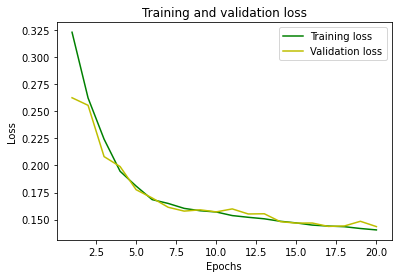

In [108]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

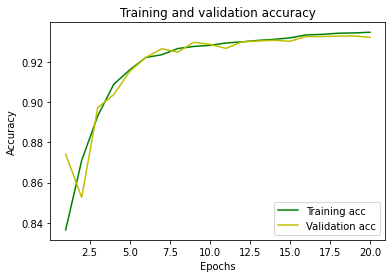

In [109]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [110]:
# Evaluation du model
model_lstm.evaluate(x_test,y_test)

1454/1454 [==============================] - 10s 7ms/step - loss: 0.1402 - accuracy: 0.9355


[0.14015312492847443, 0.9354623556137085]

In [111]:
# Prediction et affichage des performance du model
y_pred = model_lstm.predict(x)
y_pred = np.argmax(y_pred,axis=1) 
y_true = np.argmax(y,axis=1)

print("Accuracy: {}" .format(metrics.accuracy_score(y_true, y_pred)))
print("Precision: {}" .format(metrics.precision_score(y_true, y_pred, average='macro')))
print("Recall: {}" .format(metrics.recall_score(y_true, y_pred, average='macro')))
print("F1: {}" .format(metrics.f1_score(y_true, y_pred, average='macro')))


Accuracy: 0.9353924731182796
Precision: 0.9356311827376174
Recall: 0.9353924731182797
F1: 0.9353836212776752


In [102]:
y_test.shape

(46500, 2)

In [103]:
y_pred.shape

(186000,)

In [104]:
def plot_confusing_matrix (y_compare,pred,n_categories):

  cm = metrics.confusion_matrix(y_compare, pred)
  plot_confusion_matrix(conf_mat=cm,figsize=(13,13),show_normed=True)
  plt.title('Matrice de confusion')
  plt.ylabel('Cible')
  plt.xlabel('Prédite')
  plt.show()

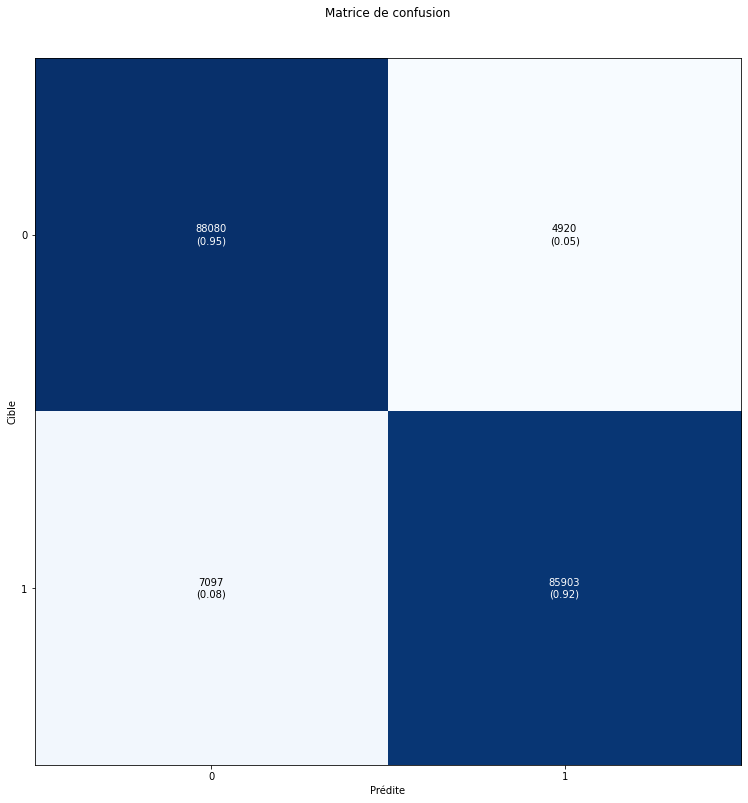

In [112]:
plot_confusing_matrix(y_true,y_pred,2)

# Nouvelle section